# Profiling: In-Depth Analysis


In [24]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [25]:
absences = pd.read_csv('./Absenteeism_at_work.csv', sep= ';')

df_personal = pd.DataFrame(columns = absences.columns)

summarized_list = []

categoricals = ['ID', 
                'Reason for absence',
                'Month of absence',
                'Day of the week',
                'Seasons',
                'Disciplinary failure',
                'Education',
                'Social drinker',
                'Social smoker'
                
               ]

#try seeing if there's a pattern for people who are sick a lot and people who aren't sick alot
IDlist = range(1,37)

from scipy import stats

for entry in IDlist:
    entry_data = []
    df_personalRecord = absences[absences.ID==entry]
    for column_name in df_personal.columns:
        if column_name in categoricals:
            entry_data.append(stats.mode(df_personalRecord[column_name])[0][0])
        else:
            entry_data.append(df_personalRecord[column_name].mean())
    summarized_list.append(entry_data)

        
df_personal = pd.DataFrame(summarized_list,columns = absences.columns)

Interesting! We expect metrics like weight, height, and BMI to be approximately normal, but both weight and BMI appear to have a bimodal curve, and height looks a bit skewed right.

# Profiling

Let's try to cluster our recorded absences using k-means. We will use one-hot encoding to handle our categorical data.

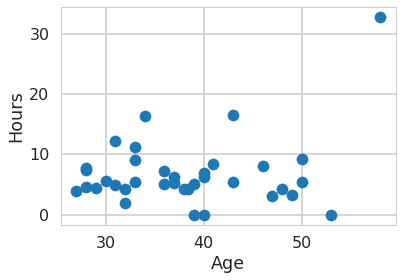

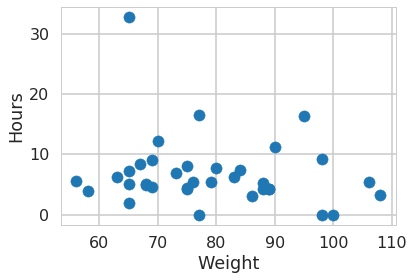

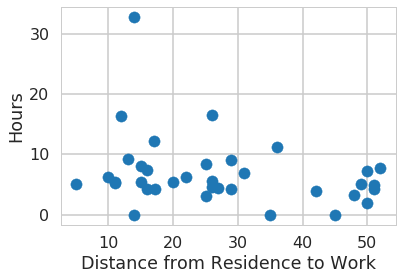

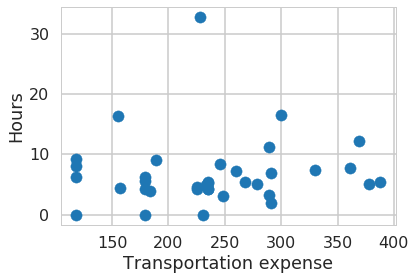

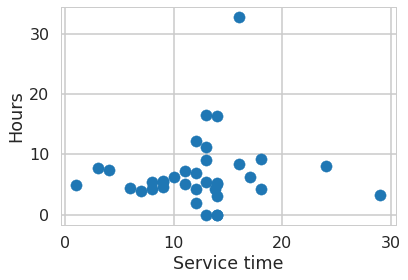

In [26]:
plt.scatter(df_personal['Age'], df_personal['Absenteeism time in hours'])
plt.xlabel('Age')
plt.ylabel('Hours')
plt.show()

plt.scatter(df_personal['Weight'], df_personal['Absenteeism time in hours'])
plt.xlabel('Weight')
plt.ylabel('Hours')
plt.show()

plt.scatter(df_personal['Distance from Residence to Work'], df_personal['Absenteeism time in hours'])
plt.xlabel('Distance from Residence to Work')
plt.ylabel('Hours')
plt.show()

plt.scatter(df_personal['Transportation expense'], df_personal['Absenteeism time in hours'])
plt.xlabel('Transportation expense')
plt.ylabel('Hours')
plt.show()

plt.scatter(df_personal['Service time'], df_personal['Absenteeism time in hours'])
plt.xlabel('Service time')
plt.ylabel('Hours')
plt.show()

As shown above, it seems like that when we examine personal averages of absence hours with respect to averages of other variables, we can't find a discernible pattern, so we conclude that there isn't a specific variable that is highly correlated with long absences. Perhaps this is because these hours are aggregated per person and stored as an average.

In [27]:
from sklearn.cluster import KMeans


In [28]:
#get dummies

absences_OHC = pd.get_dummies(absences, columns = categoricals)
absences_OHC.head()

,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Son,Pet,Weight,Height,...,Disciplinary failure_0,Disciplinary failure_1,Education_1,Education_2,Education_3,Education_4,Social drinker_0,Social drinker_1,Social smoker_0,Social smoker_1
0,289,36,13,33,239.554,97,2,1,90,172,...,1,0,1,0,0,0,0,1,1,0
1,118,13,18,50,239.554,97,1,0,98,178,...,0,1,1,0,0,0,0,1,1,0
2,179,51,18,38,239.554,97,0,0,89,170,...,1,0,1,0,0,0,0,1,1,0
3,279,5,14,39,239.554,97,2,0,68,168,...,1,0,1,0,0,0,0,1,0,1
4,289,36,13,33,239.554,97,2,1,90,172,...,1,0,1,0,0,0,0,1,1,0


Note how categorical variables have been split: for example, Education has been split into four columns for each of its levels (1,2,3,4) and each of these columns is used as an indicator to determine the level of education for a row. Now let's take look at the SS for various $k$:

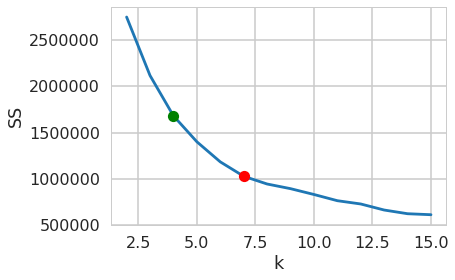

In [29]:
clusterRange = list(range(2,16))
pred_cols = absences_OHC.values
SS_list = []

for k in clusterRange:
    kmeans = KMeans(n_clusters=k,random_state=9).fit(pred_cols)
    SS_list = SS_list + [kmeans.inertia_]
    
plt.plot(clusterRange,SS_list)
plt.xlabel("k")
plt.ylabel("SS")
plt.plot(7, SS_list[5], 'ro')
plt.plot(4, SS_list[2], 'go')
plt.show()

Using the elbow method, we see that there is no apparent 'elbow', so we might initially select $k=7$ or $k=4$ clusters. In this case, we select 4 clusters as generally speaking, it's easier to find differences between groups(clusters) if there are fewer groups to compare. 

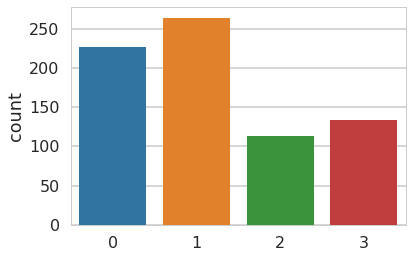

In [30]:
kmeans4 = KMeans(n_clusters=4,random_state=9).fit(pred_cols)

kmeans4_counts=sns.countplot(kmeans4.labels_)

plt.show()

absences['labels'] = kmeans4.labels_

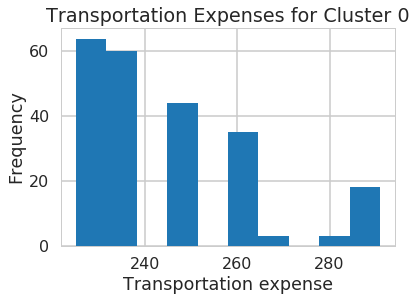

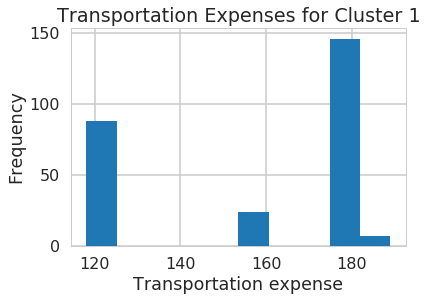

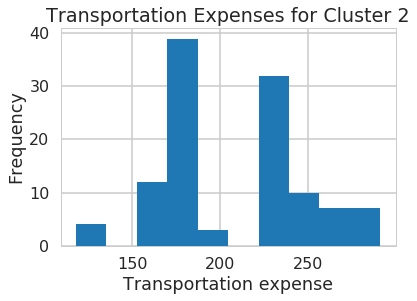

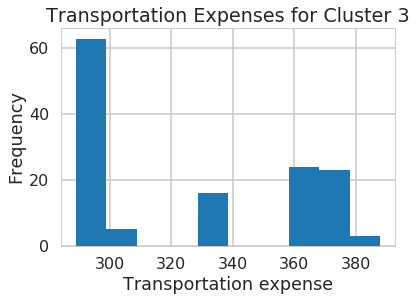

In [31]:
for val in sorted(absences.labels.unique()):
    plt.figure()
    plt.xlabel('Transportation expense')
    plt.ylabel('Frequency')
    plt.title('Transportation Expenses for Cluster %s' %val)
    plt.hist(absences[absences['labels']==val]['Transportation expense'])
    

Based on the transportation expenses, we can see a clear difference in the distributions among the groups: group 1 has mostly sub-200 expenses, group 3 has mostly expenses over 300, group 0 has mostly entries in the 200 to 260 range, while group 2 has expenses (1) around 175 and (2) over 225.

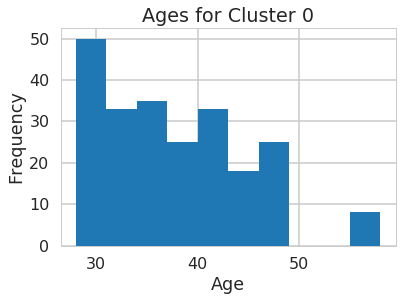

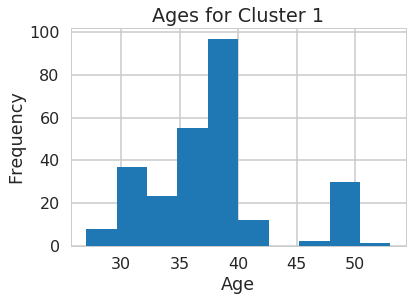

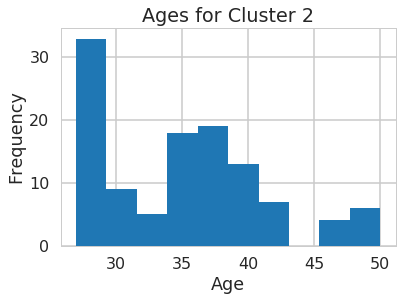

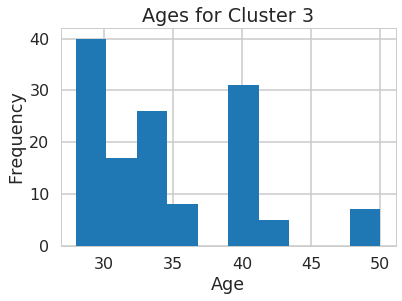

In [32]:
for val in sorted(absences.labels.unique()):
    plt.figure()
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.title('Ages for Cluster %s' %val)
    plt.hist(absences[absences['labels']==val]['Age'])

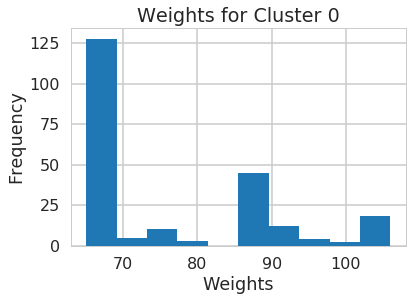

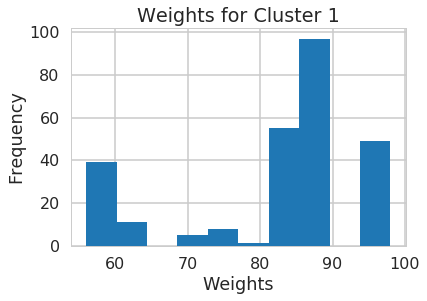

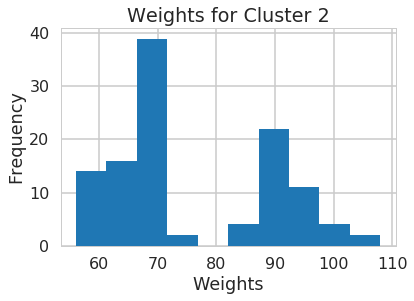

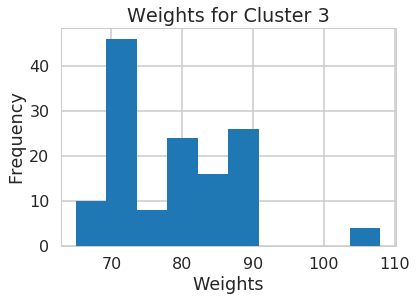

In [33]:
for val in sorted(absences.labels.unique()):
    plt.figure()
    plt.xlabel('Weights')
    plt.ylabel('Frequency')
    plt.title('Weights for Cluster %s' %val)
    plt.hist(absences[absences['labels']==val]['Weight'])

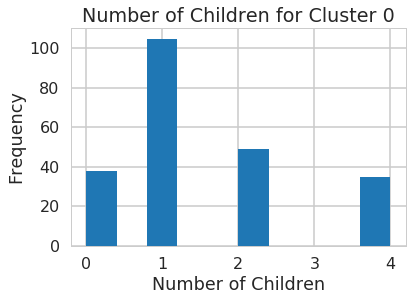

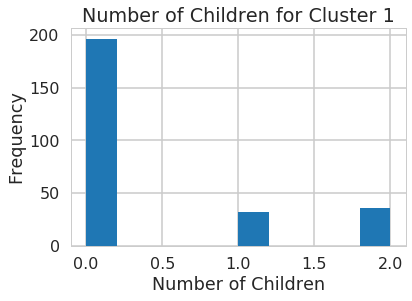

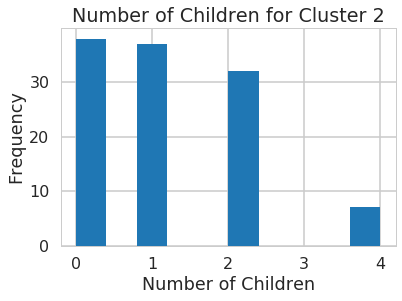

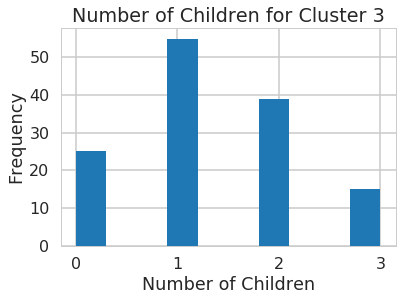

In [34]:
for val in sorted(absences.labels.unique()):
    plt.figure()
    plt.xlabel('Number of Children')
    plt.ylabel('Frequency')
    plt.title('Number of Children for Cluster %s' %val)
    plt.hist(absences[absences['labels']==val]['Son'])

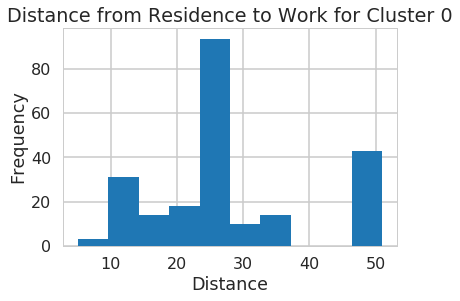

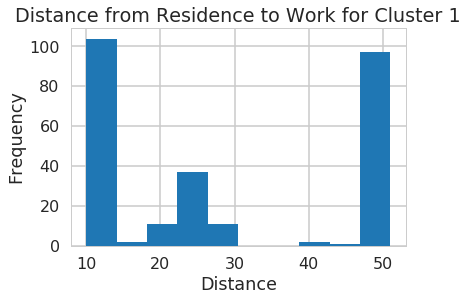

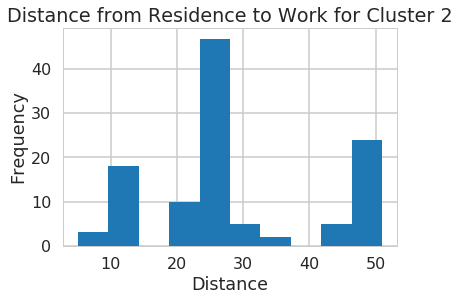

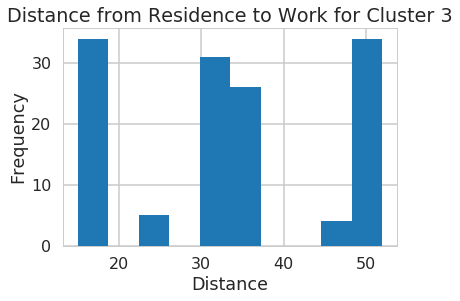

In [35]:
for val in sorted(absences.labels.unique()):
    plt.figure()
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.title('Distance from Residence to Work for Cluster %s' %val)
    plt.hist(absences[absences['labels']==val]['Distance from Residence to Work'])

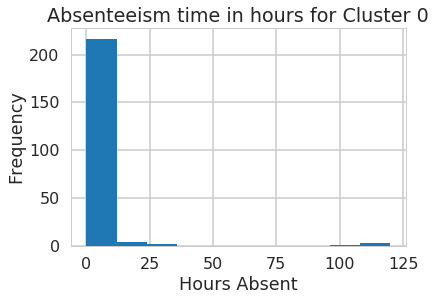

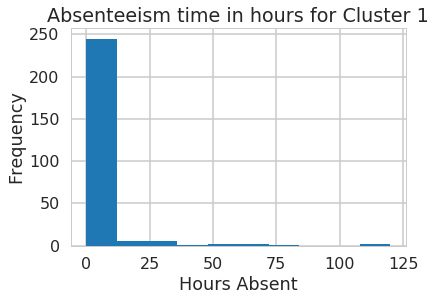

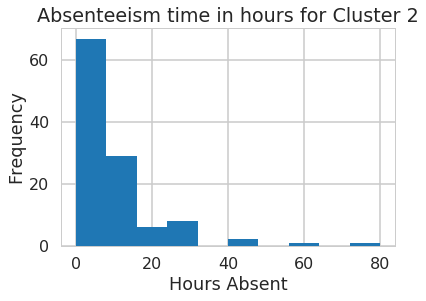

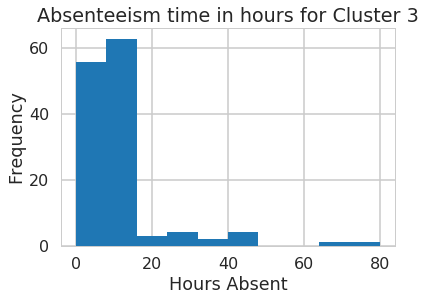

In [36]:
for val in sorted(absences.labels.unique()):
    plt.figure()
    plt.xlabel('Hours Absent')
    plt.ylabel('Frequency')
    plt.title('Absenteeism time in hours for Cluster %s' %val)
    plt.hist(absences[absences['labels']==val]['Absenteeism time in hours'])

Below we present some features of our different clusters:


|  Cluster 0   | Cluster 1 | Cluster 2 | Cluster 3
|--------------|-------------------------------------|
||Under 200 Transportation expense|Between 150 and 200 Transportation expense|At least 300 transportation expense|
|Late 20s|Late 30s to early 40s| Under 30 y.o||
| Weighs right under 70kg  | Between 80 and 90kg | | |
| Has 1 Child|No Children| | |
| Between 0 and 10 hours absent || | At least 10 hours absent| 

# Individual Profiling

Instead of trying to categorize all instances of absences, let's try to cluster the workers themselves (who we can identify through their ID)

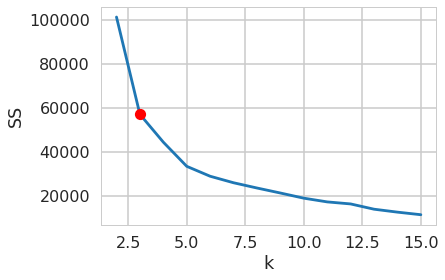

In [37]:


personals_OHC = pd.get_dummies(df_personal, columns=categoricals)
predpersonal_cols = personals_OHC.values
SSpersonal_list = []

for k in clusterRange:
    kmeans = KMeans(n_clusters=k,random_state=9).fit(predpersonal_cols)
    SSpersonal_list = SSpersonal_list + [kmeans.inertia_]
    
plt.plot(clusterRange,SSpersonal_list)
plt.xlabel("k")
plt.ylabel("SS")
plt.plot(3, SSpersonal_list[1], 'ro')
plt.show()

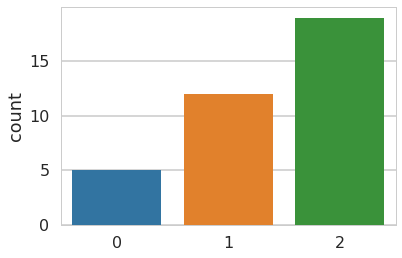

In [51]:
kmeans3 = KMeans(n_clusters=3,random_state=9).fit(predpersonal_cols)

kmeans3_counts=sns.countplot(kmeans3.labels_)

plt.show()

In [52]:
df_personal['labels'] = kmeans3.labels_

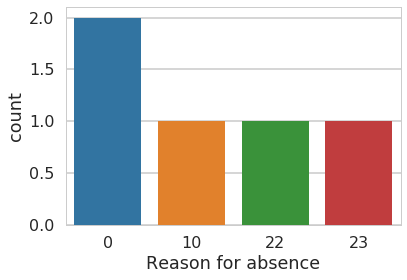

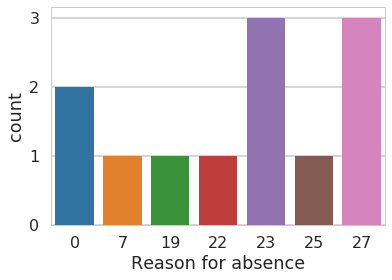

In [53]:
for i in range(0,2):
    plt.figure()
    sns.countplot(df_personal[df_personal['labels']==i]['Reason for absence'])

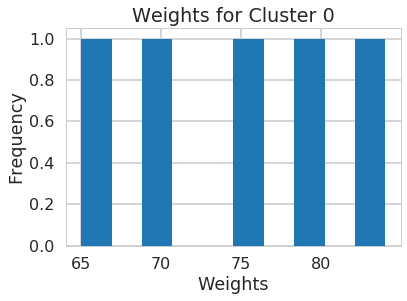

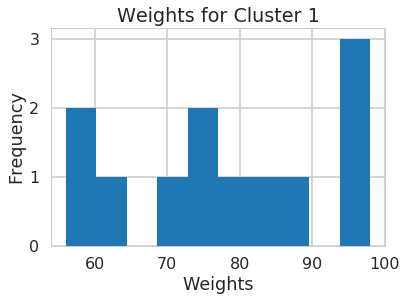

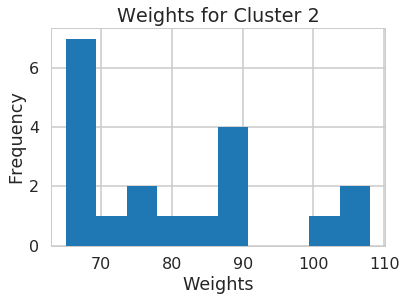

In [54]:
for val in sorted(df_personal.labels.unique()):
    plt.figure()
    plt.xlabel('Weights')
    plt.ylabel('Frequency')
    plt.title('Weights for Cluster %s' %val)
    plt.hist(df_personal[df_personal['labels']==val]['Weight'])

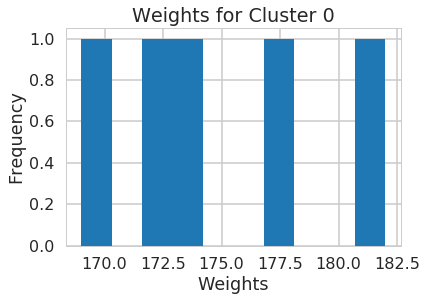

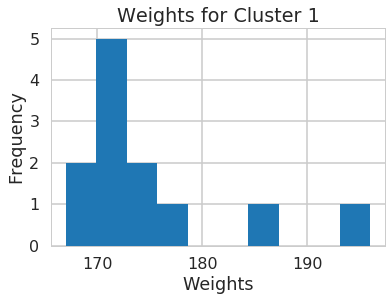

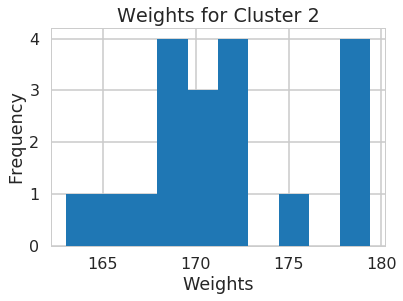

In [55]:
for val in sorted(df_personal.labels.unique()):
    plt.figure()
    plt.xlabel('Heights')
    plt.ylabel('Frequency')
    plt.title('Heights for Cluster %s' %val)
    plt.hist(df_personal[df_personal['labels']==val]['Height'])

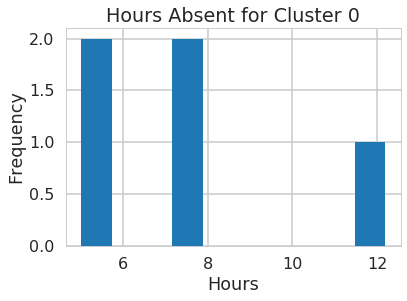

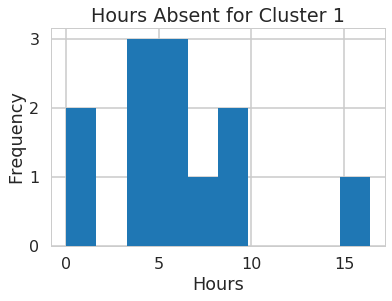

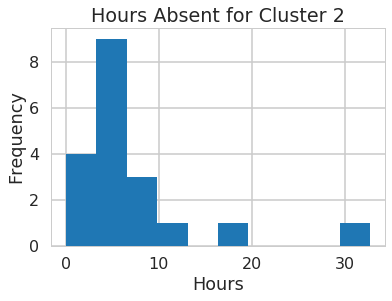

In [57]:
for val in sorted(df_personal.labels.unique()):
    plt.figure()
    plt.xlabel('Hours')
    plt.ylabel('Frequency')
    plt.title('Hours Absent for Cluster %s' %val)
    plt.hist(df_personal[df_personal['labels']==val]['Absenteeism time in hours'])

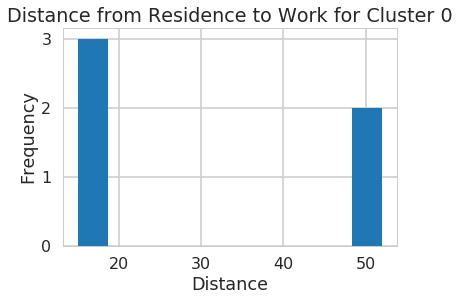

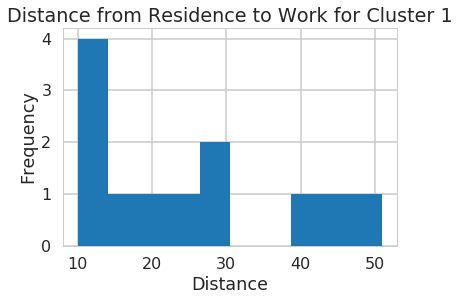

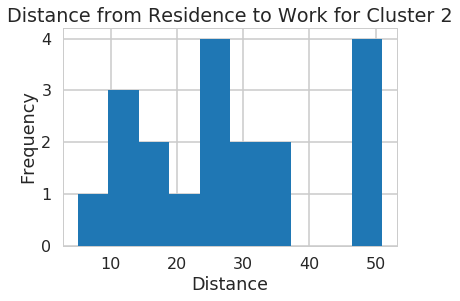

In [61]:
for val in sorted(df_personal.labels.unique()):
    plt.figure()
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.title('Distance from Residence to Work for Cluster %s' %val)
    plt.hist(df_personal[df_personal['labels']==val]['Distance from Residence to Work'])

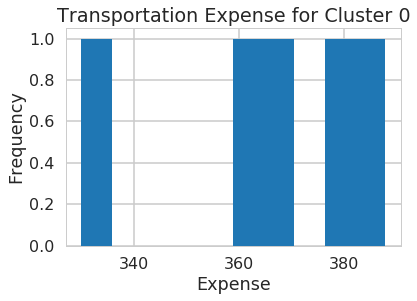

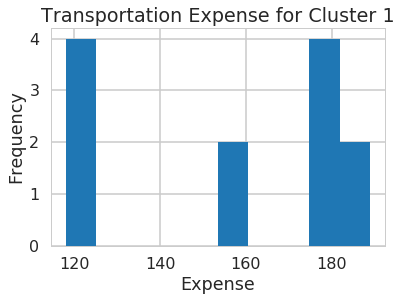

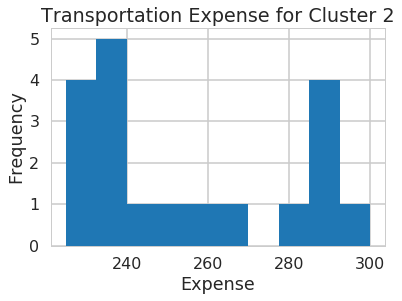

In [60]:
for val in sorted(df_personal.labels.unique()):
    plt.figure()
    plt.xlabel('Expense')
    plt.ylabel('Frequency')
    plt.title('Transportation Expense for Cluster %s' %val)
    plt.hist(df_personal[df_personal['labels']==val]['Transportation expense'])

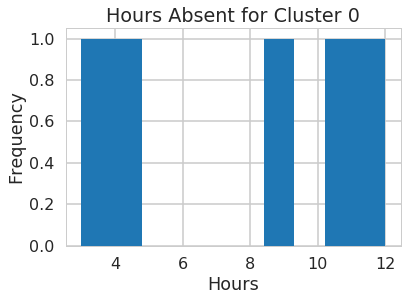

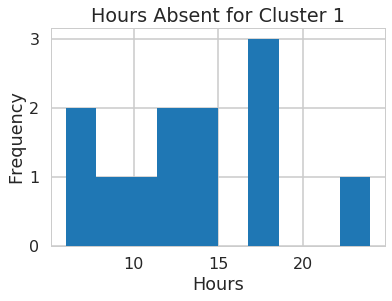

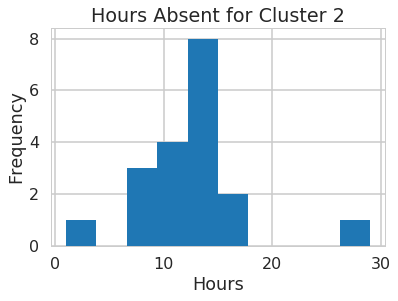

In [65]:
for val in sorted(df_personal.labels.unique()):
    plt.figure()
    plt.xlabel('Hours')
    plt.ylabel('Frequency')
    plt.title('Hours Absent for Cluster %s' %val)
    plt.hist(df_personal[df_personal['labels']==val]['Service time'])

Below we present some features of our different clusters:


|  Cluster 0   | Cluster 1 | Cluster 2 |
|--------------|-------------------------------------|
| | |Under 12 hours absent|
|High transportation cost | Low Transportation cost| Medium-priced transportation cost|
| | Heavier workers| Lighter workers  |
| | Taller workers| Shorter workers |
|| | Longer absences| 